## Booking.com Website

🌍 Booking.com Hotel Scraper + Analyzer
🔎 Starting data extraction...
✅ Page loaded
No cookie popup
⬇️ Scrolling the page to load more hotels...
🏨 Found 74 hotels
[1/74] ✅ FK Pyramids View Hotel
[2/74] ✅ New Comfort Inn Giza
[3/74] ✅ Comfort Inn Pyramids Hotel
[4/74] ✅ Revento DownTown Inn
[5/74] ✅ Pharaohs Pyramids Crypt
[6/74] ✅ Royal Inn Residence New Cairo
[7/74] ✅ Alaaeldein Golden Pyramids
[8/74] ✅ Nefertari Pyramids View Inn
[9/74] ✅ Mar Charbel Hotel Cairo
[10/74] ✅ z&m Real estate marketing
[11/74] ✅ Pyramids heart view hotel
[12/74] ✅ Secrets Of The Pyramids Hotel
[13/74] ✅ Continental de las pirámides
[14/74] ✅ Pyramids Heart Hotel
[15/74] ✅ Khattab Pyramids View Hotel
[16/74] ✅ Montana Hotel
[17/74] ✅ Karnak temple pyramids view
[18/74] ✅ Osiris Hotel Cairo
[19/74] ✅ West Pyramids Hotel
[20/74] ✅ Egypt Pyramids Hotel
[21/74] ✅ Cairo Crystal Hotel
[22/74] ✅ Comfort Sphinx & Pyramids Inn
[23/74] ✅ Falcon Pyramids INN
[24/74] ✅ Desert Glow Pyramids INN
[25/74] ✅ Mena Pyramids H

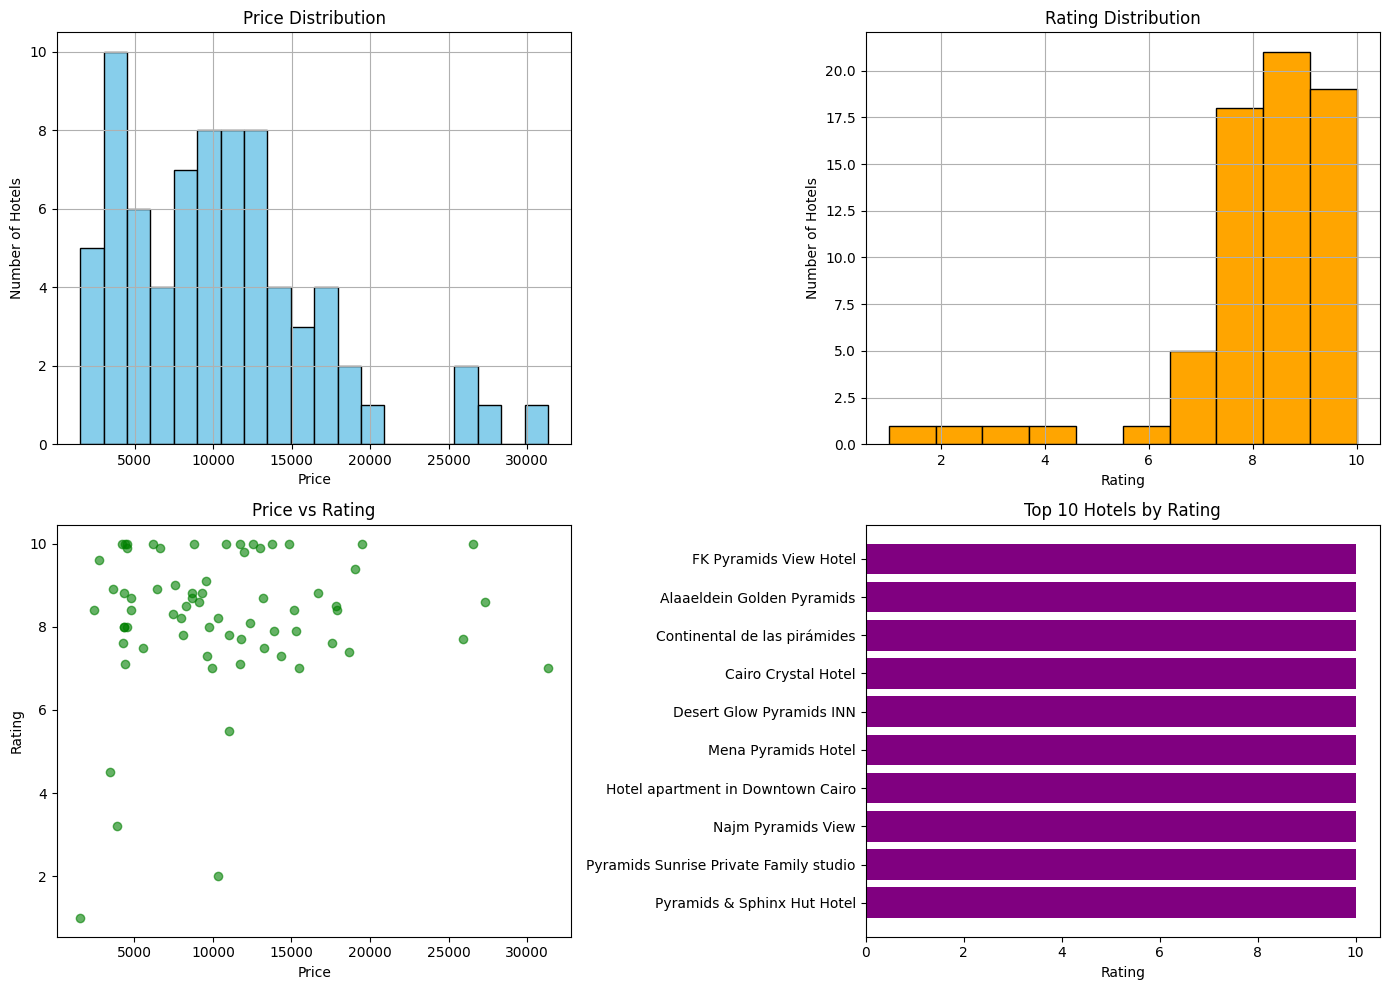

📊 Visualization saved as hotel_analysis.png
🚪 Browser closed


In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import pandas as pd
import csv
import time
import random
import re
import matplotlib.pyplot as plt
import numpy as np


# ------------------------------
# Setup Chrome Driver
# ------------------------------
def setup_driver():
    chrome_options = Options()
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--disable-blink-features=AutomationControlled")
    chrome_options.add_experimental_option("excludeSwitches", ["enable-automation"])
    chrome_options.add_experimental_option('useAutomationExtension', False)
    chrome_options.add_argument(
        "--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    )
    driver = webdriver.Chrome(options=chrome_options)
    driver.execute_script("Object.defineProperty(navigator, 'webdriver', {get: () => undefined})")
    return driver


# ------------------------------
# Scroll Function
# ------------------------------
def scroll_page(driver, scroll_pause=2, max_scroll=5):
    last_height = driver.execute_script("return document.body.scrollHeight")
    for i in range(max_scroll):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(scroll_pause)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height


# ------------------------------
# Scraping Hotels
# ------------------------------
def extract_hotel_data(driver, url, file_name):
    print("🔎 Starting data extraction...")
    try:
        driver.set_page_load_timeout(30)
        driver.get(url)
        print("✅ Page loaded")

        time.sleep(random.uniform(3, 6))

        # Accept cookies if exist
        try:
            cookie_button = WebDriverWait(driver, 8).until(
                EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler"))
            )
            cookie_button.click()
            print("🍪 Cookies accepted")
            time.sleep(2)
        except:
            print("No cookie popup")

        # Scroll
        print("⬇️ Scrolling the page to load more hotels...")
        scroll_page(driver, scroll_pause=2, max_scroll=5)

        # Collect hotels
        hotels = WebDriverWait(driver, 15).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, '[data-testid="property-card"]'))
        )
        print(f"🏨 Found {len(hotels)} hotels")

        # Save to CSV
        with open(file_name, 'w', newline='', encoding='utf-8-sig') as file:
            writer = csv.writer(file)
            writer.writerow(['Hotel Name', 'Location', 'Price', 'Rating', 'Reviews Count', 'Score', 'Link'])

            for index, hotel in enumerate(hotels, start=1):
                try:
                    # name
                    try:
                        name = hotel.find_element(By.CSS_SELECTOR, '[data-testid="title"]').text
                    except:
                        name = "Not available"

                    # location
                    try:
                        location = hotel.find_element(By.CSS_SELECTOR, '[data-testid="address"]').text
                    except:
                        location = "Not available"

                    # price
                    try:
                        price = hotel.find_element(By.CSS_SELECTOR, '[data-testid="price-and-discounted-price"]').text
                    except:
                        price = "Not available"

                    # rating & reviews
                    try:
                        review_block = hotel.find_element(By.CSS_SELECTOR, '[data-testid="review-score"]').text.split("\n")
                        score = review_block[0] if len(review_block) > 0 else "Not available"
                        reviews = review_block[1].replace("reviews", "").replace("review", "").strip() if len(review_block) > 1 else "Not available"
                    except:
                        score, reviews = "Not available", "Not available"

                    # link
                    try:
                        link = hotel.find_element(By.TAG_NAME, "a").get_attribute("href")
                    except:
                        link = "Not available"

                    writer.writerow([name, location, price, score, reviews, score, link])
                    print(f"[{index}/{len(hotels)}] ✅ {name}")

                except Exception as e:
                    print(f"⚠️ Error extracting hotel {index}: {str(e)}")

        print(f"\n📂 Data saved to: {file_name}")
        return True

    except Exception as e:
        print(f"❌ Error during extraction: {str(e)}")
        return False


# ------------------------------
# Cleaning Helper Functions
# ------------------------------
def clean_price(price_str):
    if price_str == "Not available":
        return np.nan
    try:
        price_clean = re.sub(r"[^\d]", "", str(price_str))
        return float(price_clean)
    except:
        return np.nan


def clean_rating(rating_str):
    if rating_str == "Not available":
        return np.nan
    try:
        numbers = re.findall(r"\d+\.?\d*", str(rating_str))
        return float(numbers[0]) if numbers else np.nan
    except:
        return np.nan


def clean_reviews(reviews_str):
    if reviews_str == "Not available":
        return np.nan
    try:
        numbers = re.findall(r"\d+", str(reviews_str).replace(",", ""))
        return int(numbers[0]) if numbers else np.nan
    except:
        return np.nan


# ------------------------------
# Data Analysis + Visualization
# ------------------------------
def analyze_data(file_name):
    print("\n📊 Starting Data Analysis...")

    df = pd.read_csv(file_name)

    # Clean data
    df["Price_Numeric"] = df["Price"].apply(clean_price)
    df["Rating_Numeric"] = df["Rating"].apply(clean_rating)
    df["Reviews_Numeric"] = df["Reviews Count"].apply(clean_reviews)

    print("\n✅ Cleaned Data Sample:")
    print(df.head())

    # ---- Analysis ----
    print("\n🏨 Total Hotels:", len(df))
    print("💰 Average Price:", df["Price_Numeric"].mean())
    print("⭐ Average Rating:", df["Rating_Numeric"].mean())
    print("📝 Average Reviews:", df["Reviews_Numeric"].mean())

    # ---- Visualization ----
    plt.figure(figsize=(14, 10))

    # Histogram - Prices
    plt.subplot(2, 2, 1)
    df["Price_Numeric"].dropna().hist(bins=20, color="skyblue", edgecolor="black")
    plt.title("Price Distribution")
    plt.xlabel("Price")
    plt.ylabel("Number of Hotels")

    # Histogram - Ratings
    plt.subplot(2, 2, 2)
    df["Rating_Numeric"].dropna().hist(bins=10, color="orange", edgecolor="black")
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Number of Hotels")

    # Scatter Price vs Rating
    plt.subplot(2, 2, 3)
    plt.scatter(df["Price_Numeric"], df["Rating_Numeric"], alpha=0.6, color="green")
    plt.title("Price vs Rating")
    plt.xlabel("Price")
    plt.ylabel("Rating")

    # Top Hotels by Rating
    plt.subplot(2, 2, 4)
    top_hotels = df.nlargest(10, "Rating_Numeric").dropna(subset=["Rating_Numeric"])
    plt.barh(top_hotels["Hotel Name"], top_hotels["Rating_Numeric"], color="purple")
    plt.title("Top 10 Hotels by Rating")
    plt.xlabel("Rating")
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.savefig("hotel_analysis.png", dpi=300)
    plt.show()
    print("📊 Visualization saved as hotel_analysis.png")


# ------------------------------
# Main Function
# ------------------------------
def main():
    print("🌍 Booking.com Hotel Scraper + Analyzer")

    url = input("Please enter the search URL: ")
    file_name = input("Please enter the filename (without extension): ")

    if not file_name.endswith(".csv"):
        file_name += ".csv"

    driver = setup_driver()

    try:
        if extract_hotel_data(driver, url, file_name):
            analyze_data(file_name)
    finally:
        driver.quit()
        print("🚪 Browser closed")


if __name__ == "__main__":
    main()
